In [1]:
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

Using TensorFlow backend.
/Users/kevinlu/anaconda3/envs/dsi/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/kevinlu/anaconda3/envs/dsi/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/kevinlu/anaconda3/envs/dsi/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/kevinlu/anaconda

In [2]:
df = pd.read_csv('../data/creditcard.csv')

# standard scale Amount
ss = StandardScaler()
df['normAmount'] = ss.fit_transform(pd.DataFrame(df['Amount']))

# drop Time and Amount
df.drop(columns = ['Time','Amount'], inplace = True)

X = df.drop(columns = 'Class')
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

# create SMOTE
sm = SMOTE(random_state = 42)
X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train.ravel())


In [3]:
# datset with stratify
X_train_sf, X_test_sf, y_train_sf, y_test_sf = train_test_split(X, y, stratify = y, random_state = 42)


X_train_sm_sf, y_train_sm_sf = sm.fit_sample(X_train_sf, y_train_sf.ravel())

In [4]:
def plot_confusion_matrix(cm,title):
    plt.figure(figsize = (8,8))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.xticks(ticks = [0,1],
               labels = ['predict normal','predict fraud'], 
               size = 12)
    plt.yticks(ticks = [0,1],
               labels = ['actual normal','actual fraud'], 
               size = 12)

    # cm.max() shows the larger value for class 0 and 1
    thresh = cm.max() / 2.
    
    # cm.shape = (2,2), i,j shows (0,0,1,1), (1,0,1,0)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        # cm[i,j] only works with confusion_matrix without pd.DataFrame, it shows each data in matrix
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', size =20)
    plt.xlabel('Predicted label', size = 20)
    plt.title(title, size = 30)

In [5]:
def feature_importance(model,df = X_train_sm):
    predictors = [x for x in df.columns]
    feat_imp = pd.Series(model.feature_importances_,predictors).sort_values(ascending = False)
    
    plt.figure(figsize = (8,6))
    feat_imp.plot(kind = 'bar')
    plt.ylabel('Feature Importance Score')
    plt.title('Feature Importance', size = 20);

In [6]:
def model_vis(model, index):
    prediction_train = model.predict(X_train)
    prediction_test = model.predict(X_test)
    
    cnf_train = confusion_matrix(y_train, prediction_train)
    cnf_test = confusion_matrix(y_test, prediction_test)
    
    recall_train = cnf_train[1,1] / (cnf_train[1,1] + cnf_train[1,0])
    recall_test = cnf_test[1,1] / (cnf_test[1,1] + cnf_test[1,0])
    
    precision_train = cnf_train[1,1] / (cnf_train[1,1] + cnf_train[0,1])
    precision_test = cnf_test[1,1] / (cnf_test[1,1] + cnf_test[0,1])
    
    roc_train = roc_auc_score(y_train, prediction_train)
    roc_test = roc_auc_score(y_test, prediction_test)

    result = {
        'false_positive_test' : cnf_test[0,1],
        'false_negative_test' : cnf_test[1,0],
        'recall_train' : recall_train, 
        'recall_test' : recall_test,
        'precision_train' : precision_train, 
        'precision_test' : precision_test,
        'roc_train' : roc_train,
        'roc_test' : roc_test,
    }
    
    output = pd.DataFrame(result,index = [index])
    
    plot_train = plot_confusion_matrix(cnf_train,f'{index} train')
    plot_test = plot_confusion_matrix(cnf_test,f'{index} test')
    
    feature_chart = feature_importance(model)
    
    return output

# Baseline

,false_positive_test,false_negative_test,recall_train,recall_test,precision_train,precision_test,roc_train,roc_test
default,805,11,0.960422,0.902655,0.134865,0.112459,0.974736,0.945666


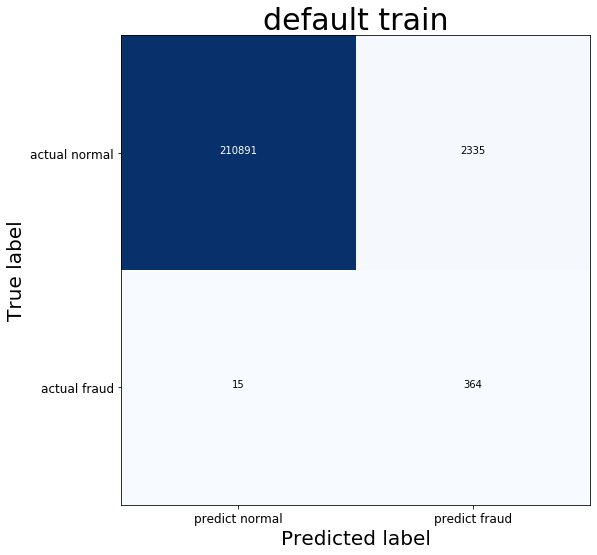

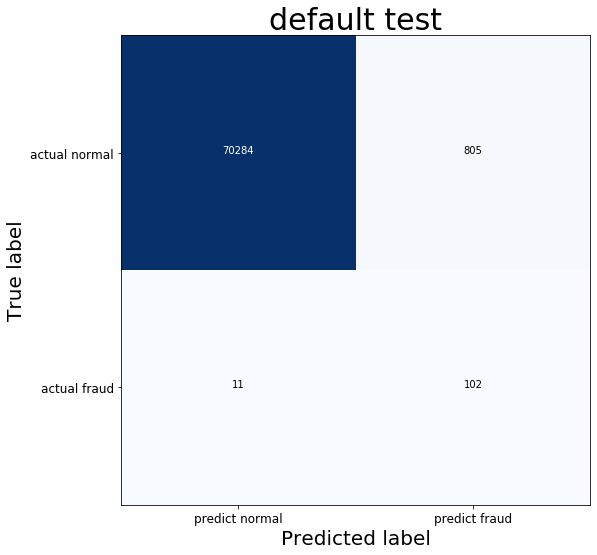

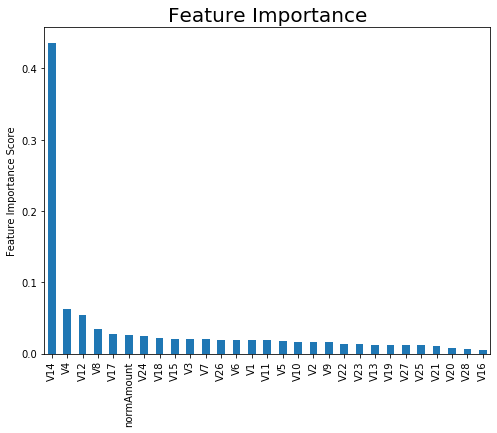

In [7]:
xgb = XGBClassifier(random_state=42)
model = xgb.fit(X_train_sm, y_train_sm.ravel())
model_vis(model,'default')

,false_positive_test,false_negative_test,recall_train,recall_test,precision_train,precision_test,roc_train,roc_test
default stratify,814,6,0.944591,0.946903,0.128684,0.116178,0.966611,0.967726


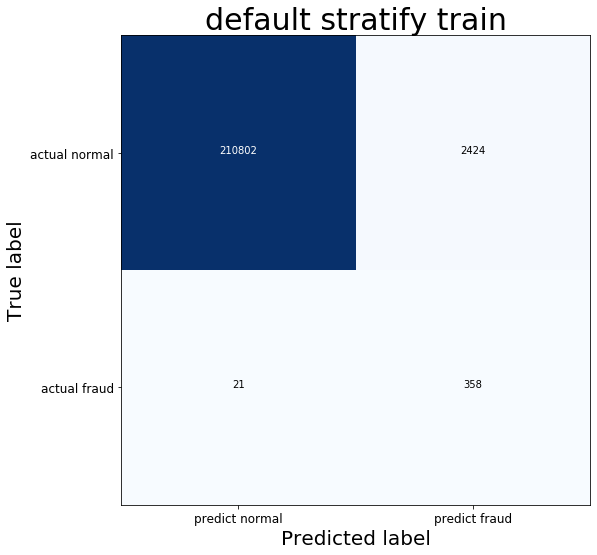

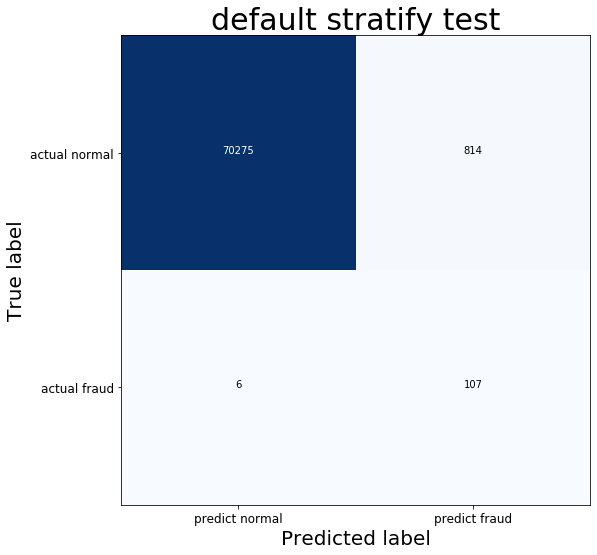

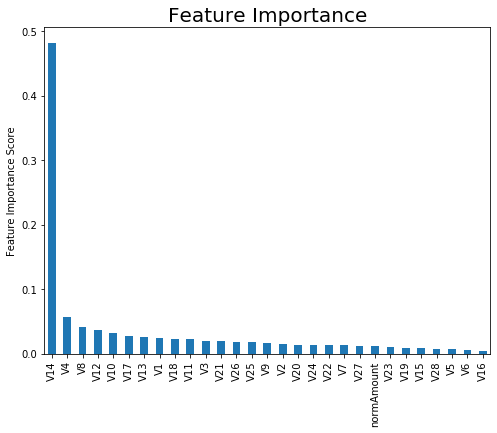

In [8]:
model = xgb.fit(X_train_sm_sf, y_train_sm_sf.ravel())
model_vis(model,'default stratify')

### Proceed with stratified data

# Param tuning

In [ ]:
# https://medium.com/@gabrieltseng/gradient-boosting-and-xgboost-c306c1bcfaf5
# https://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/

In [13]:
# max_depth, learning_rate, n_estimator
# reg_alpha: L1 regularization weights (go to 0), reg_lambda, L2 regularization weights (small)
# subsample, colsample_bytree, colsample_bylevel, colsample_bynode
# gamma: minimum loss reduction required to further split
# early_stopping

### step 1: n_estimators, learning_rate, max_depth

In [9]:
grid_param = {
    'n_estimators':[100,200,500],
    'learning_rate':[0.1,0.05,0.02],
    'max_depth':[3,4,5]
}

gs1 = GridSearchCV(XGBClassifier(random_state=42),
                   param_grid=grid_param,
                   cv=5,
                   n_jobs=4,
                   verbose=3)

In [10]:
gs1.fit(X_train_sm_sf,y_train_sm_sf.ravel())

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed: 94.3min
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed: 518.6min
[Parallel(n_jobs=4)]: Done 135 out of 135 | elapsed: 617.5min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=42, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=4,
             param_grid={'learning_rate': [0.1, 0.05, 0.02],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 500]},
          

In [11]:
gs1.best_params_,gs1.best_score_

({'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500},
 0.9997162769827208)

In [12]:
pd.DataFrame(gs1.cv_results_).sort_values(by = 'rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
8,2309.991143,5.698243,4.633186,0.064638,0.1,5,500,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.999648,0.999707,0.999707,0.999719,0.999801,0.999716,0.000049,1
5,1922.960186,2.834305,3.842746,0.079478,0.1,4,500,"{'learning_rate': 0.1, 'max_depth': 4, 'n_esti...",0.999437,0.999566,0.999601,0.999496,0.999613,0.999543,0.000067,2
17,2362.573063,7.029146,4.587669,0.078271,0.05,5,500,"{'learning_rate': 0.05, 'max_depth': 5, 'n_est...",0.999320,0.999285,0.999449,0.999320,0.999437,0.999362,0.000067,3
7,964.691394,0.771166,1.653740,0.030839,0.1,5,200,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.999191,0.998968,0.999285,0.999027,0.999074,0.999109,0.000114,4
2,1844.670688,181.531818,3.006831,0.100998,0.1,3,500,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.998816,0.998722,0.998921,0.998945,0.998874,0.998856,0.000080,5
14,1921.439644,4.685256,3.630056,0.034699,0.05,4,500,"{'learning_rate': 0.05, 'max_depth': 4, 'n_est...",0.998746,0.998452,0.998734,0.998675,0.998546,0.998631,0.000114,6
4,789.736662,1.997546,1.317016,0.011678,0.1,4,200,"{'learning_rate': 0.1, 'max_depth': 4, 'n_esti...",0.998054,0.997819,0.997972,0.998136,0.997948,0.997986,0.000106,7
16,960.005026,2.972470,1.520288,0.013916,0.05,5,200,"{'learning_rate': 0.05, 'max_depth': 5, 'n_est...",0.995920,0.995510,0.995826,0.996612,0.996178,0.996009,0.000369,8
11,1480.623218,1.529143,2.815893,0.027712,0.05,3,500,"{'learning_rate': 0.05, 'max_depth': 3, 'n_est...",0.996131,0.995580,0.996014,0.996190,0.996049,0.995993,0.000215,9
26,2169.172875,224.622943,3.756907,0.903576,0.02,5,500,"{'learning_rate': 0.02, 'max_depth': 5, 'n_est...",0.995826,0.995580,0.995768,0.996213,0.996026,0.995882,0.000218,10


In [19]:
grid_xgb = XGBClassifier(learning_rate = 0.1, 
                         max_depth = 5, 
                         n_estimators=500, 
                         random_state=42, 
                         n_jobs=4)
eval_set = [(X_train, y_train),(X_test,y_test)]

# model = grid_xgb.fit(X_train_sm_sf, 
#                      y_train_sm_sf.ravel(),
#                      eval_set=eval_set, 
#                      eval_metric = ['error','auc'],
#                      early_stopping_rounds = 5, 
#                      verbose = True)          #result: FN = 7, FP = 1080

model = grid_xgb.fit(X_train_sm_sf, y_train_sm_sf.ravel())

In [16]:
# result = model.evals_result()

,false_positive_test,false_negative_test,recall_train,recall_test,precision_train,precision_test,roc_train,roc_test
gridsearch 1,14,8,0.968338,0.929204,0.924433,0.882353,0.984099,0.964503


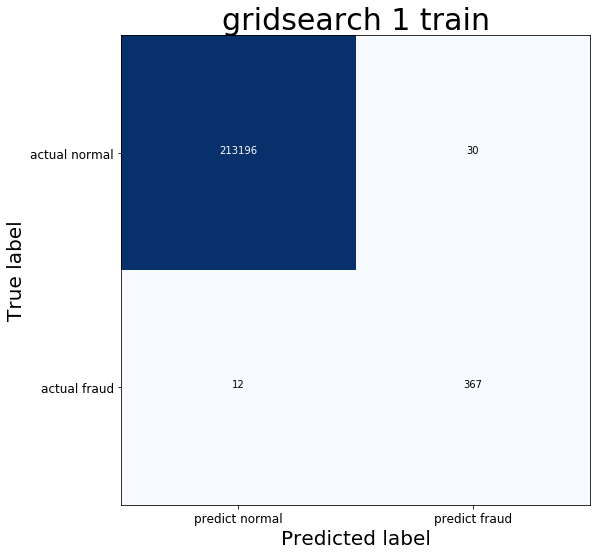

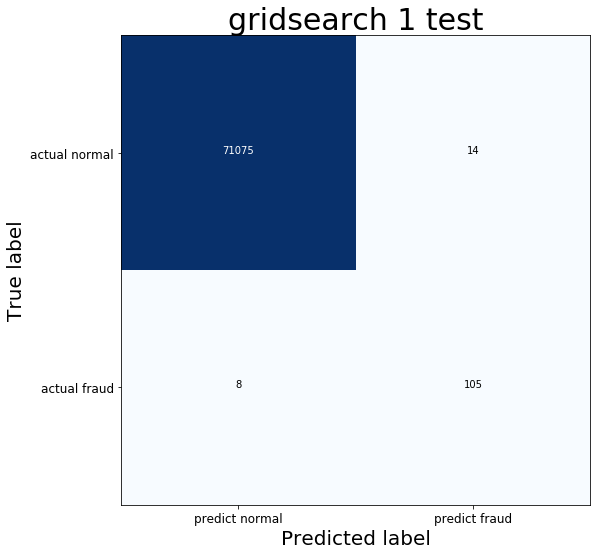

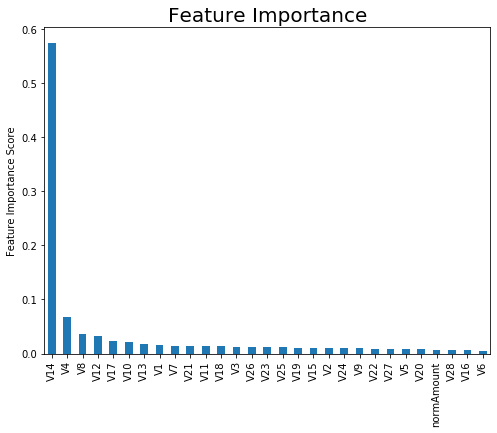

In [20]:
model_vis(model,'gridsearch 1')

### Step 2: reg alpha, reg lambda

In [22]:
grid_param = {
    'reg_alpha': [0,0.5,1,10,20],
    'reg_lambda': [0,0.5,1,10,20]
}

gs2 = GridSearchCV(XGBClassifier(learning_rate = 0.1, 
                                 max_depth = 5, 
                                 n_estimators=500, 
                                 random_state=42),
                   param_grid=grid_param, 
                   cv = 5, 
                   verbose=3, 
                   n_jobs=4)
gs2.fit(X_train_sm_sf, y_train_sm_sf.ravel())

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed: 266.5min
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed: 881.3min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=5, min_child_weight=1,
                                     missing=None, n_estimators=500, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=42, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=4,
             param_grid={'reg_alpha': [0, 0.5, 1, 10, 20],
                         'reg_lambda': [0, 0.5, 1, 10, 20]},
             pre_dispatch='2*n_jobs', refit=True, return_tr

In [23]:
gs2.best_params_,gs2.best_score_

({'reg_alpha': 0, 'reg_lambda': 0.5}, 0.9997467597009141)

In [25]:
gs1.best_score_

0.9997162769827208

In [24]:
pd.DataFrame(gs2.cv_results_).sort_values(by = 'rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_reg_alpha,param_reg_lambda,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,2320.528496,33.104678,5.215488,0.528483,0,0.5,"{'reg_alpha': 0, 'reg_lambda': 0.5}",0.999660,0.999730,0.999766,0.999742,0.999836,0.999747,0.000057,1
0,2928.508864,292.700816,4.789260,0.021142,0,0,"{'reg_alpha': 0, 'reg_lambda': 0}",0.999683,0.999648,0.999754,0.999766,0.999824,0.999735,0.000062,2
5,1533.014771,26.265611,3.499366,0.172068,0.5,0,"{'reg_alpha': 0.5, 'reg_lambda': 0}",0.999578,0.999719,0.999719,0.999730,0.999883,0.999726,0.000097,3
11,1194.985031,2.179392,3.036194,0.079329,1,0.5,"{'reg_alpha': 1, 'reg_lambda': 0.5}",0.999683,0.999683,0.999707,0.999730,0.999824,0.999726,0.000052,4
6,1422.134382,80.944657,3.295879,0.354914,0.5,0.5,"{'reg_alpha': 0.5, 'reg_lambda': 0.5}",0.999648,0.999660,0.999730,0.999742,0.999824,0.999721,0.000064,5
7,1234.245922,54.789849,2.995115,0.017082,0.5,1,"{'reg_alpha': 0.5, 'reg_lambda': 1}",0.999625,0.999672,0.999730,0.999730,0.999836,0.999719,0.000071,6
10,1190.756512,6.723645,3.022826,0.035845,1,0,"{'reg_alpha': 1, 'reg_lambda': 0}",0.999660,0.999695,0.999730,0.999683,0.999824,0.999719,0.000057,7
2,2589.231604,244.372172,6.014322,0.274642,0,1,"{'reg_alpha': 0, 'reg_lambda': 1}",0.999648,0.999707,0.999707,0.999719,0.999801,0.999716,0.000049,8
12,1263.016384,74.027456,3.094343,0.081450,1,1,"{'reg_alpha': 1, 'reg_lambda': 1}",0.999613,0.999672,0.999742,0.999707,0.999836,0.999714,0.000074,9
3,2705.254236,78.100882,6.151622,0.190900,0,10,"{'reg_alpha': 0, 'reg_lambda': 10}",0.999613,0.999625,0.999695,0.999660,0.999789,0.999676,0.000063,10


In [27]:
grid_xgb = XGBClassifier(learning_rate = 0.1, 
                         max_depth = 5, 
                         n_estimators=500, 
                         reg_alpha=0,
                         reg_lambda=0.5,
                         random_state=42, 
                         n_jobs=4)

model = grid_xgb.fit(X_train_sm_sf, y_train_sm_sf.ravel())

,false_positive_test,false_negative_test,recall_train,recall_test,precision_train,precision_test,roc_train,roc_test
gridsearch 2,12,7,0.968338,0.938053,0.933842,0.898305,0.984108,0.968942


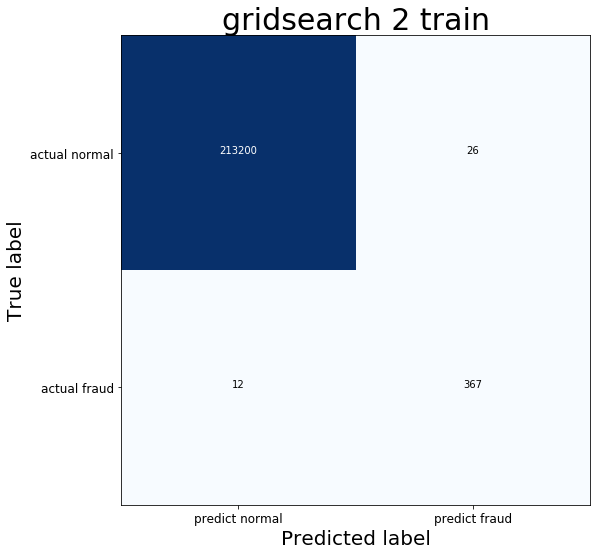

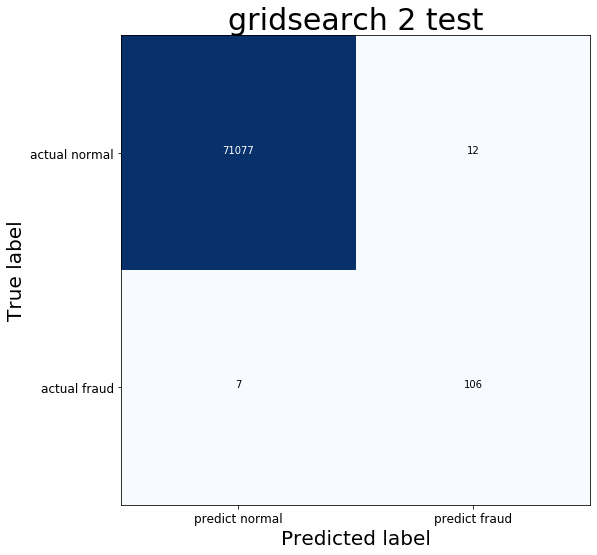

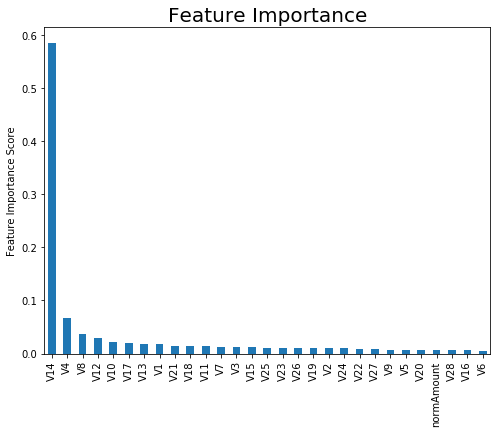

In [28]:
model_vis(model,'gridsearch 2')